# AR Modeller
Denne notebook bruger jeg til at lege lidt rundt med AR modeller, i håb om at finde og dokumentere viden omkring dem

## Udregning af densitet
Det er rimelig let at se at processen er stationær (givet en guassisk støj omkring 0), og at $x_i\sim \mathcal{N}(0, \Sigma)$ for alle $i=1,\ldots$.
For en AR model af orden 1 findes densiteten for alle indgange rimelig let på lukket form. Problemet opstår ved modeller af højere orden.

Tag en model af orden $p$. Overvej indgang modellen til tidspunkt $k$. Vi kan dekomponere $x_k$ i en linear kombination (se def. på AR(p)). Det giver os $p$ nye variable, der alle kan dekomponeres. Derfor er det tydeligt at siden $\omega_i\overset{i.i.d.}{\sim}\mathcal{N}(0, \Sigma)$ så må $x_i$ være gaussisk for alle $i$. Problemet er at det eksploderer kombinatorisk, og jeg tror ikke der findes en lukket form for udvidelsen af de udtryk. I tilfælde af at der gør kan koden nedenunder skrives mere effektivt.

Jeg vil skrive koden så den kan bruges til at udregne variancen, så vi kender densiteten for $x_i$ for alle $i$. Jeg kan så se på hvordan variansen for $x_i$ udvikler sig over tid (kun den er relevant da vores mean altid er 0, se stationær). Så kan jeg kigge på det analytiske udtryk for $I(Y;Z)$, hvor $Y$ og $Z$ er indgange i $X_i$. Hvis det ikke bliver bollet for meget af en ændrende varians tror jeg godt vi kan bruge det til at label noget lin. data. Hvis den er følsom over for variansen så er jeg ikke sikker på at vi kan label det direkte. Så kan det være vi istedet skal kigge på hvordan Granger Causality relaterer sig til MI.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_AR(coefficient_list, variance, num_time_steps, x0=0):
    """
    Simulates an AR process for some given parameters. Alongside this it calculates the variance of the nth entry of the simulation
    giving a known distribution of each variable.

    :param coefficient_list: list of coefficient matrices for the AR model (even for p=1 give as list)
    :param variance: covariance matrix for the gaussian noise
    :param num_time_steps: number of iterations the filter should take
    :param x0: starting condition (if specified the generation will ignore the density calculation of the series)
    :return:
    :array series: time series simulation of the model
    :array variance: variance of the series indexed according to 'series'
    """

    # Get dimension of the input and set 0-vector and get model order
    d = variance.shape[0]
    p = len(coefficient_list)

    # --------------
    # Simulate AR(p)
    # --------------
    outputs = np.zeros((num_time_steps + 1, d))
    outputs[0] = x0

    for i in range(1, num_time_steps + 1):
        iter_sum = np.zeros(d)

        for j in range(p):
            try:
                iter_sum += coefficient_list[j] @ outputs[i - (p + 1)]
            except IndexError:
                break

        iter_sum += np.random.multivariate_normal(mean=np.zeros(d), cov=variance)
        outputs[i] = iter_sum

    # Check if we should calculate the variances of the model. If not we return outputs
    if type(x0) != int:
        return outputs
    if x0 != 0:
        return outputs

    # ------------------------------------
    # Calculate the variances of the model
    # ------------------------------------
    def ai(var, Ai):
        """
        Useful function for calculating the running variance at time step

        :param var: variance of the i-previous time-step
        :param Ai: coefficient matrix to multiply with i-previous time step
        :return: the product Ai @ var @ Ai.T
        """
        return Ai @ var @ Ai.T

    # Create the vector holding variances, along with a list to hold previous variances needed for the calculation
    variances = np.zeros((num_time_steps + 1, d, d))
    p_prev_var = [np.zeros((d, d)) for i in range(p)]

    # Initialize the vector holding all variances and the list to calculate new var
    variances[0] = variance
    p_prev_var[0] = variance

    for i in range(1, num_time_steps + 1):
        # Calculate new variance
        new_var_list = [ai(old_var, coefficient_list[i]) for i, old_var in enumerate(p_prev_var)]
        new_var = sum(new_var_list) + variance

        # add new variace to p_prev_var list and remove oldest entry
        new_var_list.insert(0, new_var)
        del new_var_list[-1]

        # Add the new variance calculated to the vector holding all variances
        variances[i] = new_var

    return outputs, variances


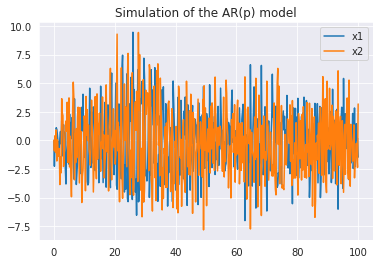

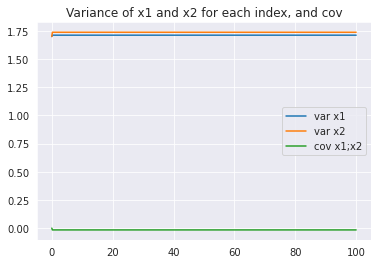

In [3]:
# ------------------------------------------
# Hent resultater fra en simulering af AR(p)
# ------------------------------------------
# A, var = [np.random.randn(2, 2) * 0.2] * 8, np.identity(2) + np.identity(2).T * 0.7
A, var = np.load("stable_coef_order8.npy"), np.identity(2) + np.identity(2).T * 0.7
N = 500
result, variances = generate_AR(A, var, N)
t = np.linspace(0, 1, N + 1) * 100

# ----
# plot
# ----
plt.title("Simulation of the AR(p) model")
plt.plot(t, result[:, 0], label="x1")
plt.plot(t, result[:, 1], label="x2")
plt.legend()
plt.show()

plt.title("Variance of x1 and x2 for each index, and cov")
plt.plot(t, variances[:, 0, 0], label="var x1")
plt.plot(t, variances[:, 1, 1], label="var x2")
plt.plot(t, variances[:, 1, 0], label="cov x1;x2")
plt.legend()
plt.show()

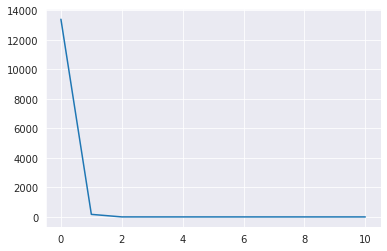

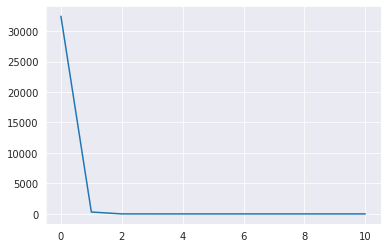

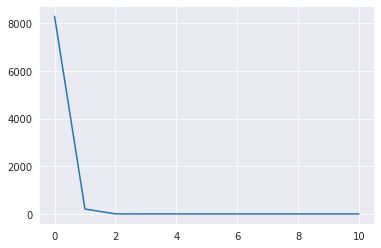

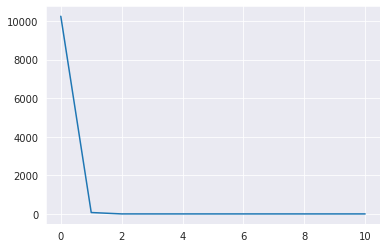

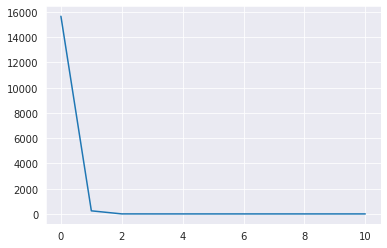

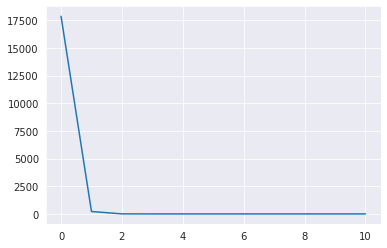

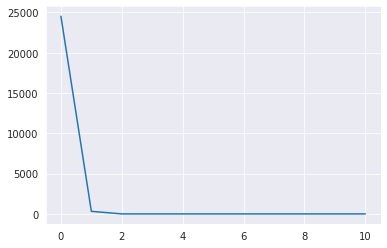

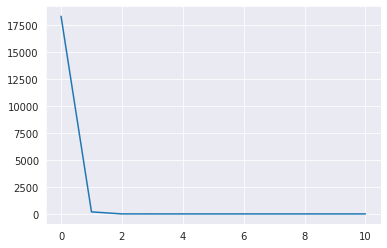

In [4]:
"""
Det kan sagtens ske at der er en fejl i koden. Vi kan nemlig se at de varianser der ligger langt tilbage ikke har meget
indflydelse på den nuværende varians (det kan ses ved at printe p_prev_var i funktionen).

Det her er bare skrevet for at illustrere at coef. matricerne er nilpotente, hvilket medfører at den gentagende multiplikation
ender ud i 0. Jeg ved ikke om det gælder for matricer som ikke er nilpotente, eller hvilke betingelser der skal til før at vi
får den konvergerende varianse vi gerne vil have.
"""
for A_choice in A:
    B = np.random.randn(2, 2) * 10e3
    As = [B]
    for i in range(10):
        As.append(A_choice @ As[i] @ A_choice.T)

    As_norms = [np.linalg.norm(As_entr) for As_entr in As]
    plt.plot(As_norms)
    plt.show()

## Fucker rundt med AR
Alt nedenstående er baseret på [denne intro fra statsmodels](https://www.statsmodels.org/devel/examples/notebooks/generated/autoregressions.html).
Der er værktøjer til visualisering og fit af AR modeller på reel data.

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [6]:
# set plot styles
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

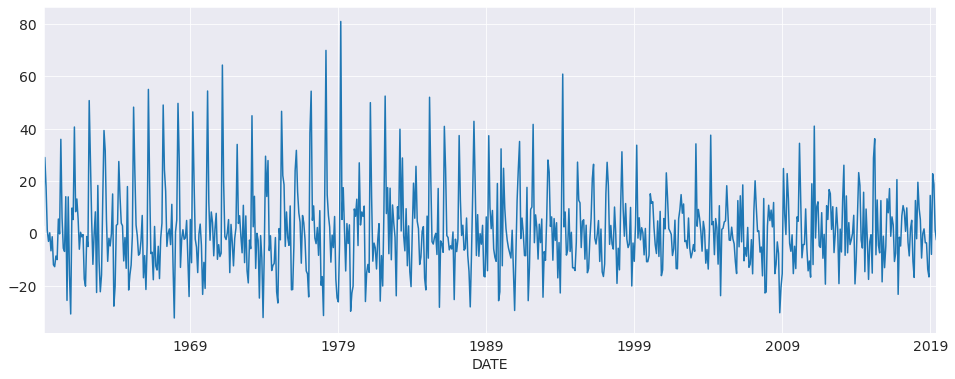

In [7]:
data = pdr.get_data_fred("HOUSTNSA", "1959-01-01", "2019-06-01")
housing = data.HOUSTNSA.pct_change().dropna()
housing = 100 * housing.asfreq("MS")
fig, ax = plt.subplots()
ax = housing.plot(ax=ax)

In [8]:
# Simpelt fit af data
model = AutoReg(housing, 3, old_names=False)
result = model.fit()
print(result.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  725
Model:                     AutoReg(3)   Log Likelihood               -2993.442
Method:               Conditional MLE   S.D. of innovations             15.289
Date:                Thu, 15 Sep 2022   AIC                           5996.884
Time:                        14:00:52   BIC                           6019.794
Sample:                    05-01-1959   HQIC                          6005.727
                         - 06-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.1228      0.573      1.961      0.050       0.000       2.245
HOUSTNSA.L1     0.1910      0.036      5.235      0.000       0.120       0.263
HOUSTNSA.L2     0.0058      0.037      0.155    

In [9]:
sel = ar_select_order(housing, 13, old_names=False)
result = sel.model.fit()
print(result.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  725
Model:                    AutoReg(13)   Log Likelihood               -2676.157
Method:               Conditional MLE   S.D. of innovations             10.378
Date:                Thu, 15 Sep 2022   AIC                           5382.314
Time:                        14:00:52   BIC                           5450.835
Sample:                    03-01-1960   HQIC                          5408.781
                         - 06-01-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.3615      0.458      2.970      0.003       0.463       2.260
HOUSTNSA.L1     -0.2900      0.036     -8.161      0.000      -0.360      -0.220
HOUSTNSA.L2     -0.0828      0.031     -2.65

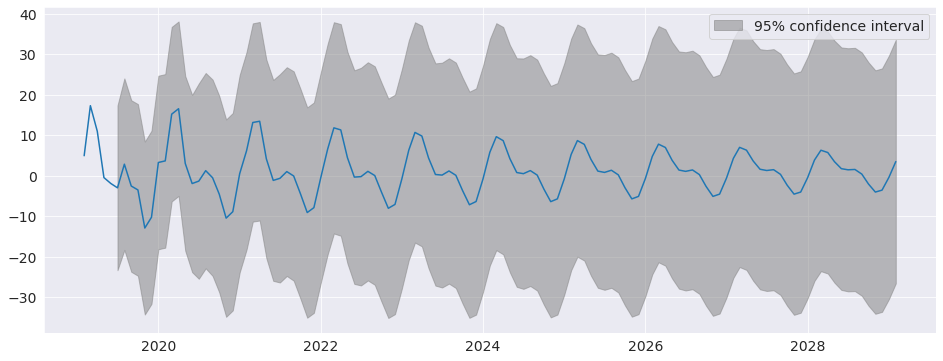

In [10]:
# visualize forecast
_ = result.plot_predict(720, 840)

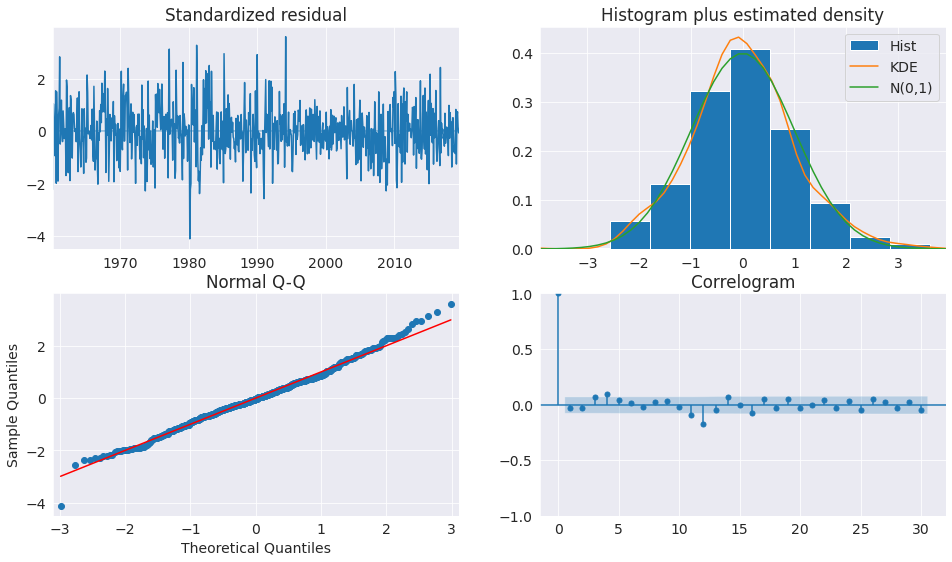

In [11]:
fig = plt.figure(figsize=(16, 9))
fig = result.plot_diagnostics(fig=fig, lags=30)